# Proyecto 02 — MAP (Charting Student Math Misunderstandings)
### Paso #5 — Análisis Exploratorio de Datos (EDA)

Este cuaderno necesita que se corra el **Paso #4 (Preprocesamiento)** con `main.ipynb` y que existen los archivos:
- `./data/preprocessed/train_preprocessed.csv`
- `./data/preprocessed/test_preprocessed.csv`

**Objetivos del EDA**:
1. Describir cuántas variables y observaciones hay en el dataset y sus tipos de datos.
2. Resumir variables numéricas (medidas de tendencia central y dispersión).
3. Elaborar tablas de frecuencia para variables categóricas.
4. Realizar cruces entre variables clave para detectar patrones relevantes.
5. Generar gráficos exploratorios (histogramas, diagramas de cajas, dispersión, barras, etc.).

In [1]:
# Imports y configuración
import os, json, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuración general
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 200)

DATA_DIR = Path("./data")
PP_DIR   = DATA_DIR / "preprocessed"
TRAIN_PP = PP_DIR / "train_preprocessed.csv"
TEST_PP  = PP_DIR / "test_preprocessed.csv"

OUT_DIR  = Path("./eda_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Validación de existencia de archivos
assert TRAIN_PP.exists() and TEST_PP.exists(), (
    "No se encontraron los archivos preprocesados. "
    "Ejecuta primero main.ipynb y verifica las rutas en ./data/preprocessed/"
)

print("Archivos detectados:")
print(" -", TRAIN_PP.resolve())
print(" -", TEST_PP.resolve())
print("Resultados/figuras se guardarán en:", OUT_DIR.resolve())

Archivos detectados:
 - C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\data\preprocessed\train_preprocessed.csv
 - C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\data\preprocessed\test_preprocessed.csv
Resultados/figuras se guardarán en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs


In [2]:
# Carga de datos
train = pd.read_csv(TRAIN_PP)
test  = pd.read_csv(TEST_PP)

print("Tamaños:")
print(" - train:", train.shape)
print(" - test :", test.shape)

# Columnas esperadas y presentes
print("\nColumnas disponibles en train:")
print(train.columns.tolist())

print("\nVista rápida de train:")
display(train.head(5))

Tamaños:
 - train: (36696, 15)
 - test : (3, 11)

Columnas disponibles en train:
['row_id', 'QuestionId', 'QuestionText', 'MC_Answer', 'StudentExplanation', 'Category', 'Misconception', 'StudentExplanation_clean', 'len_chars', 'len_words', 'num_digits', 'num_mathops', 'has_latex', 'Category_id', 'Misconception_id']

Vista rápida de train:


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,StudentExplanation_clean,len_chars,len_words,num_digits,num_mathops,has_latex,Category_id,Misconception_id
0,0,31772,What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.],\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,0ne third is equal to tree nineth,33,7,1,0,False,3,21
1,1,31772,What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.],\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third is not shaded.,True_Correct,NaN,1 / 3 because 6 over 9 is 2 thirds and 1 third is not shaded.,61,16,6,1,False,3,21
2,2,31772,What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.],\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to understand.",True_Neither,NaN,"1 3rd is half of 3 6th, so it is simplee to understand.",55,13,4,0,False,5,21
3,3,31772,What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.],\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN,1 goes into everything and 3 goes into nine,43,9,2,0,False,5,21
4,4,31772,What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.],\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN,1 out of every 3 isn't coloured,31,7,2,0,False,3,21


## Forma, tipos de datos, valores faltantes y duplicados

In [3]:
# Tipos de datos y conteo de faltantes
print("Tipos de datos (train):")
display(train.dtypes.to_frame("dtype"))

print("\nValores faltantes por columna (train):")
missing = train.isna().sum().sort_values(ascending=False)
display(missing.to_frame("n_missing"))

# Duplicados considerando un subconjunto razonable de columnas de identidad de fila
subset_cols = ["QuestionId", "MC_Answer", "StudentExplanation_clean"]
dup_count = train.duplicated(subset=subset_cols).sum()
print(f"\nDuplicados por {subset_cols}: {dup_count}")

canon_map = {
    "Wrong_Fraction": "Wrong_fraction",
    "": "NA",
}
train["Misconception"] = train["Misconception"].replace(canon_map)


Tipos de datos (train):


,dtype
row_id,int64
QuestionId,int64
QuestionText,object
MC_Answer,object
StudentExplanation,object
Category,object
Misconception,object
StudentExplanation_clean,object
len_chars,int64
len_words,int64



Valores faltantes por columna (train):


,n_missing
Misconception,26836
QuestionId,0
row_id,0
QuestionText,0
MC_Answer,0
StudentExplanation,0
Category,0
StudentExplanation_clean,0
len_chars,0
len_words,0



Duplicados por ['QuestionId', 'MC_Answer', 'StudentExplanation_clean']: 861


**Nota: ~75% de Misconception está vacío. Eso no es (necesariamente) “faltante aleatorio”; es, más bien, faltante estructural: solo debería existir una etiqueta de Misconception cuando la fila pertenece a una categoría con malentendido (p. ej., True_Misconception, False_Misconception). Para el resto (p. ej., *_Correct, *_Neither), lo normal es que Misconception sea NA/”no aplica”.****

## Resumen de variables numéricas
Se consideran, entre otras, las variables derivadas del preprocesamiento:  
- `len_chars`, `len_words`, `num_digits`, `num_mathops`

In [4]:
# Estadísticos descriptivos de variables numéricas
num_cols = [c for c in ["len_chars", "len_words", "num_digits", "num_mathops"] if c in train.columns]
desc = train[num_cols].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T
display(desc)

# Guardar resumen numérico
desc_out = OUT_DIR / "numerical_summary.csv"
desc.to_csv(desc_out)
print("Resumen numérico guardado en:", desc_out.resolve())

,count,mean,std,min,5%,25%,50%,75%,95%,max
len_chars,36696.0,69.777196,38.440621,1.0,29.0,43.0,60.0,86.0,145.0,586.0
len_words,36696.0,15.357832,8.121211,1.0,6.0,10.0,13.0,19.0,31.0,177.0
num_digits,36696.0,4.719397,4.609988,0.0,0.0,1.0,4.0,7.0,13.0,101.0
num_mathops,36696.0,1.001444,1.654262,0.0,0.0,0.0,0.0,2.0,4.0,49.0


Resumen numérico guardado en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\numerical_summary.csv


- La mediana es 60 chars y 13 palabras (p75: 86 chars y 19 palabras; p95: 145 chars y 31 palabras). Es decir, la mayoría de explicaciones son breves; hay cola derecha con pocos casos muy largos (máx. 586 chars, 177 palabras).
- Uso de dígitos frecuente pero moderado: Mediana 4 dígitos (p75: 7; p95: 13), con outliers (máx. 101). Indica que muchas explicaciones referencian números/decimales, útil para features de conteo de dígitos.
- Operadores matemáticos poco comunes: mediana 0, p75 2, p95 4; media ≈ 1. La mayoría de explicaciones son textuales; unas pocas incluyen operaciones explícitas (outliers hasta 49).

## Tablas de frecuencia para variables categóricas
- `Category` (solo train)  
- `Misconception` (solo train) — se recomienda ver Top‑N por su cola larga

In [5]:
# Frecuencias categóricas
def freq_table(series: pd.Series, top=None):
    vc = series.value_counts(dropna=False)
    if top is not None:
        vc = vc.head(top)
    df = pd.DataFrame({"count": vc, "pct": (vc / vc.sum() * 100).round(2)})
    return df

# Category
if "Category" in train.columns:
    cat_freq = freq_table(train["Category"])
    display(cat_freq)
    cat_freq.to_csv(OUT_DIR / "freq_Category.csv")
    print("Frecuencia Category guardada.")

# Misconception (Top 20)
if "Misconception" in train.columns:
    mis_freq_top20 = freq_table(train["Misconception"], top=20)
    display(mis_freq_top20)
    mis_freq_top20.to_csv(OUT_DIR / "freq_Misconception_top20.csv")
    print("Frecuencia Misconception (Top20) guardada.")

,count,pct
Category,,
True_Correct,14802,40.34
False_Misconception,9457,25.77
False_Neither,6542,17.83
True_Neither,5265,14.35
True_Misconception,403,1.10
False_Correct,227,0.62


Frecuencia Category guardada.


,count,pct
Misconception,,
NaN,26836,74.54
Incomplete,1454,4.04
Additive,929,2.58
Duplication,704,1.96
Wrong_fraction,691,1.92
Subtraction,620,1.72
Positive,566,1.57
Wrong_term,558,1.55
Irrelevant,497,1.38


Frecuencia Misconception (Top20) guardada.


#### **Category**

- Fuerte desbalance: dos clases concentran la mayoría — True_Correct 40.34% y False_Misconception 25.77%. Les siguen False_Neither 17.83% y True_Neither 14.35%. Las minoritarias True_Misconception 1.10% y False_Correct 0.62% serán difíciles.

#### **Misconception**

- NA/No aplica domina con 74.54%, consistente con que solo una parte de las filas debería llevar etiqueta específica (cuando la categoría es “Misconception”).

- Entre las etiquetas presentes (25.46%) hay cabeza pronunciada:

    - Top 5: Incomplete 4.04, Additive 2.58, Duplication 1.96, Wrong_fraction 1.92, Subtraction 1.72 → ≈48% de todos los casos etiquetados.

    - Top 10 cubre ≈74% de los etiquetados; el resto es cola.

---

## Cruces entre variables clave
- `Category` × `Misconception`  
- `Category` × `QuestionId` (muestra de IDs más frecuentes)  
- Longitud de explicación por clase (boxplots en 5.e)

In [6]:
# %% Crosstabs / Tablas de contingencia
# Category x Misconception
if "Category" in train.columns and "Misconception" in train.columns:
    ct_cat_mis = pd.crosstab(train["Category"], train["Misconception"])
    display(ct_cat_mis.iloc[:, :20])  # Mostrar primeras 20 columnas por legibilidad
    ct_cat_mis.to_csv(OUT_DIR / "crosstab_Category_Misconception.csv")
    print("Crosstab Category x Misconception guardada.")

# Category x QuestionId (para top QuestionId por tamaño)
qid_sizes = train["QuestionId"].value_counts().head(15).index if "QuestionId" in train.columns else []
if len(qid_sizes) and "Category" in train.columns:
    sub = train[train["QuestionId"].isin(qid_sizes)]
    ct_cat_qid = pd.crosstab(sub["Category"], sub["QuestionId"])
    display(ct_cat_qid)
    ct_cat_qid.to_csv(OUT_DIR / "crosstab_Category_TopQuestionId.csv")
    print("Crosstab Category x Top QuestionId guardada.")

Misconception,Adding_across,Adding_terms,Additive,Base_rate,Certainty,Definition,Denominator-only_change,Division,Duplication,Firstterm,FlipChange,Ignores_zeroes,Incomplete,Incorrect_equivalent_fraction_addition,Interior,Inverse_operation,Inversion,Irrelevant,Longer_is_bigger,Mult
Category,,,,,,,,,,,,,,,,,,,,
False_Misconception,306,97,891,22,18,51,332,58,698,96,74,23,1446,7,50,21,409,409,23,345
True_Misconception,1,0,38,1,0,3,4,5,6,11,4,0,8,2,0,0,5,88,1,8


Crosstab Category x Misconception guardada.


QuestionId,31772,31774,31777,31778,32829,32833,32835,33471,33472,33474,76870,89443,91695,104665,109465
Category,,,,,,,,,,,,,,,
False_Correct,31,19,35,19,9,9,16,16,47,3,5,3,11,2,2
False_Misconception,1605,617,390,1296,271,1113,380,431,645,676,383,692,646,115,197
False_Neither,873,561,586,564,160,382,262,221,457,457,290,965,406,59,299
True_Correct,1719,1405,1628,1140,1580,1235,954,701,1014,323,366,641,1234,435,427
True_Misconception,16,20,0,126,1,11,19,6,7,7,3,164,19,4,0
True_Neither,613,493,170,495,135,355,701,167,630,300,139,589,294,58,126


Crosstab Category x Top QuestionId guardada.




#### Category × Misconception

* **Patrones nítidos por tipo de error**:

  * En **True\_Misconception (n=403)**, dos etiquetas dominan: **Tacking = 162 (\~40%)** e **Irrelevant = 88 (\~22%)**. Es decir, cuando el estudiante acierta la opción pero su razonamiento es defectuoso, suele ser por “agregar/pegar” pasos superficiales o dar explicaciones no pertinentes.
  * En **False\_Misconception (n=9457)**, la cabeza está en **Incomplete = 1446 (\~15%)**, **Additive = 891 (\~9%)**, **Duplication = 698 (\~7%)**, **Subtraction = 618 (\~6.5%)**, **Positive = 564 (\~6%)**, **Wrong\_term = 550 (\~5.8%)**. También destacan errores de fracciones: **Wrong\_fraction = 412 (\~4.4%)** y **Wrong\_Fraction = 273 (\~2.9%)** (si se **unen** como una sola etiqueta, rondan **\~7.2%**), además de **Denominator-only\_change (\~3.5%)**, **Adding\_across (\~3.2%)**, y **Whole\_numbers\_larger (\~3.5%)**.
* **Lectura pedagógica**: los **errores operativos/clásicos** (suma/resta equivocada, duplicación, fracciones mal tratadas) se asocian más a **respuestas incorrectas**; mientras que las **explicaciones superficiales/irrelevantes** aparecen desproporcionadamente en **respuestas correctas con malentendido**.


#### Category × QuestionId

* **Fuerte heterogeneidad por ítem**:

  * Algunos QIDs están **enriquecidos** en `True_Misconception` (p. ej., **89443** con **164** casos ≈ **5.4%** del total de ese ítem, muy por encima del **1.1%** global), mientras otros **no tienen ninguno** (p. ej., **109465** con **0**).
  * Hay QIDs con **altísima tasa de errores específicos** (p. ej., **31778** con **False\_Misconception = 1296**), lo que sugiere que ciertos enunciados **inducen** patrones de malentendido muy concretos.

---

## Gráficos exploratorios
> Nota: Para mantener compatibilidad, los gráficos usan **matplotlib** (sin seaborn) y se generan **uno por figura**.  
Se guardan copias en `./eda_outputs/`.

## Histograma: longitud en palabras

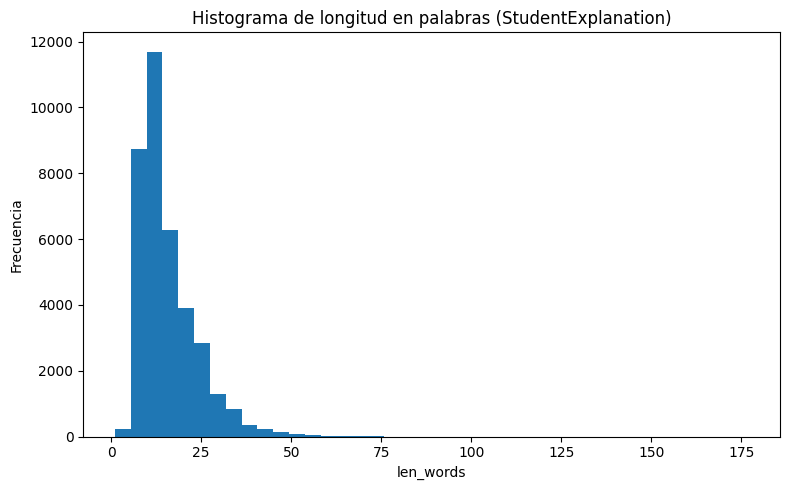

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\hist_len_words.png


In [7]:
if "len_words" in train.columns:
    plt.figure(figsize=(8,5))
    plt.hist(train["len_words"].dropna(), bins=40)
    plt.title("Histograma de longitud en palabras (StudentExplanation)")
    plt.xlabel("len_words")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    fig_path = OUT_DIR / "hist_len_words.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Longitud en palabras (StudentExplanation)

* **Sesgo a la derecha** claro: la masa está entre **5–20 palabras**, con cola larga.
* El pico coincide con la **mediana ≈ 13**; a partir de **\~30 palabras** (p95) ya es raro y >50 es muy inusual.
* Implicación: con textos tan **cortos**, funcionan bien **n-gramas de carácter** y modelos con `max_length` moderado (p. ej., 128 tokens).
---

## Histograma: número de dígitos


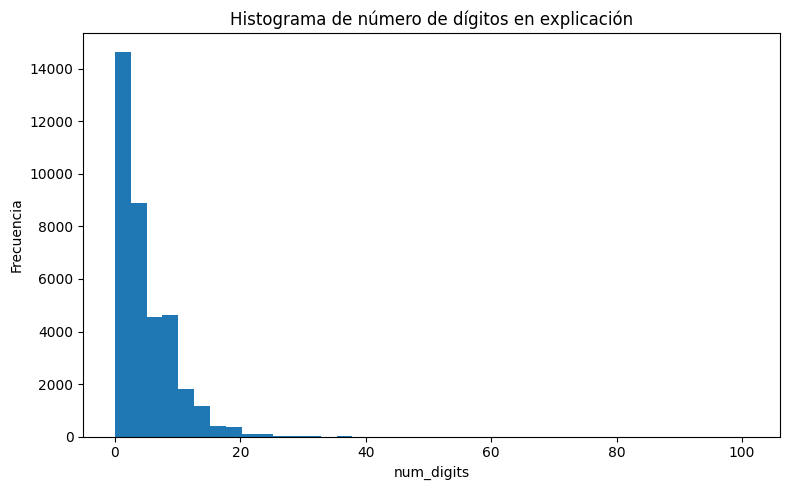

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\hist_num_digits.png


In [8]:
if "num_digits" in train.columns:
    plt.figure(figsize=(8,5))
    plt.hist(train["num_digits"].dropna(), bins=40)
    plt.title("Histograma de número de dígitos en explicación")
    plt.xlabel("num_digits")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    fig_path = OUT_DIR / "hist_num_digits.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Número de dígitos en la explicación

* Distribución también **sesgada**: muchos casos con **0–5 dígitos**, pero con **cola** que llega a outliers (hasta **101**).
* Hay indicios de **mezcla de dos comportamientos**: explicaciones puramente verbales (0 dígitos) vs. explicaciones con cálculo explícito (muchos dígitos).
* Implicación: `num_digits` por sí solo no basta, pero combinado con **operadores** o patrones (fracciones/decimales) puede discriminar etiquetas como `Wrong_fraction`, `Adding_across`, `Denominator-only_change`.
---

## Barras: distribución de Category

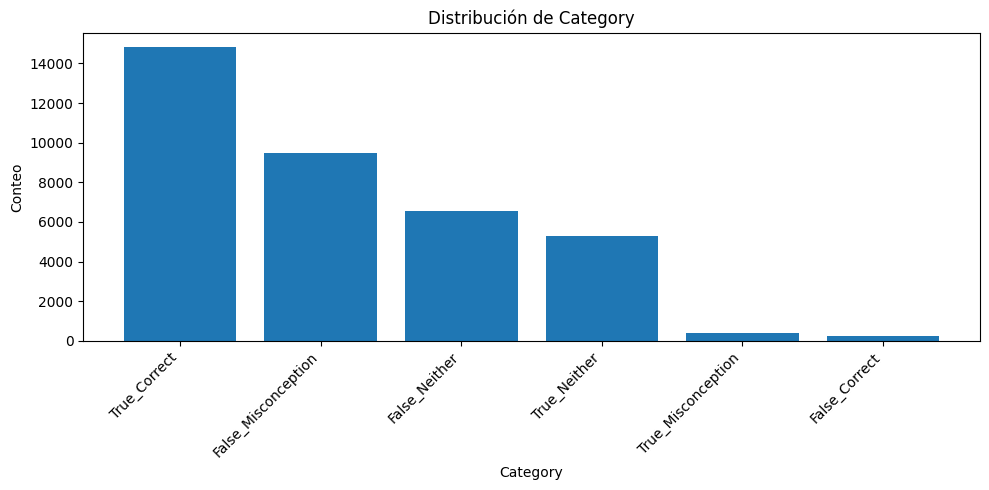

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\bar_Category.png


In [9]:

if "Category" in train.columns:
    vc = train["Category"].value_counts()
    plt.figure(figsize=(10,5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Distribución de Category")
    plt.xlabel("Category")
    plt.ylabel("Conteo")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fig_path = OUT_DIR / "bar_Category.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Distribución de `Category`

* **Desbalance pronunciado**: dominan `True_Correct` y `False_Misconception`; `True_Misconception` y `False_Correct` son muy minoritarias.
---


## Barras: Misconception (Top 20)

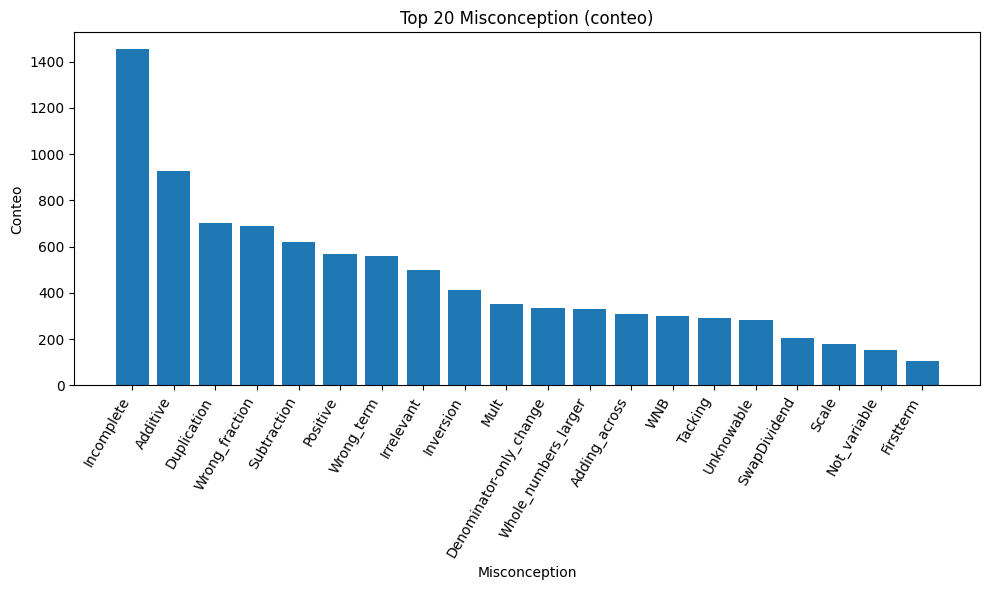

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\bar_Misconception_top20.png


In [10]:

if "Misconception" in train.columns:
    vc = train["Misconception"].value_counts().head(20)
    plt.figure(figsize=(10,6))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title("Top 20 Misconception (conteo)")
    plt.xlabel("Misconception")
    plt.ylabel("Conteo")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    fig_path = OUT_DIR / "bar_Misconception_top20.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

* **Cabeza muy marcada:** `Incomplete` sigue siendo la más frecuente, seguida por `Additive`, `Duplication`, `Wrong_fraction` y `Subtraction`. Estas 5 etiquetas concentran una porción sustancial de los casos etiquetados y merecen **atención especial** en la Tarea 3.
* **Cola larga controlada:** a partir de \~la 10.ª–12.ª etiqueta el conteo cae progresivamente. Esto sugiere usar **class weights / focal loss** y reportar **macro-F1 por clase**.
* **Señal de features:**

  * `Incomplete`: típicamente **menos palabras** y **pocos dígitos/operadores** → útil cruzar con `len_words`, `num_digits`, `num_mathops`.
  * `Wrong_fraction`, `Denominator-only_change`, `Adding_across`, `SwapDividend`: mirar **patrones de fracciones/decimales** y símbolos.
  * `Additive`, `Duplication`, `Subtraction`: presencia de **operadores** y términos comparativos.

---

## Boxplot: longitud de explicación por Category


C:\Users\n8nug\AppData\Local\Temp\ipykernel_25744\284501435.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


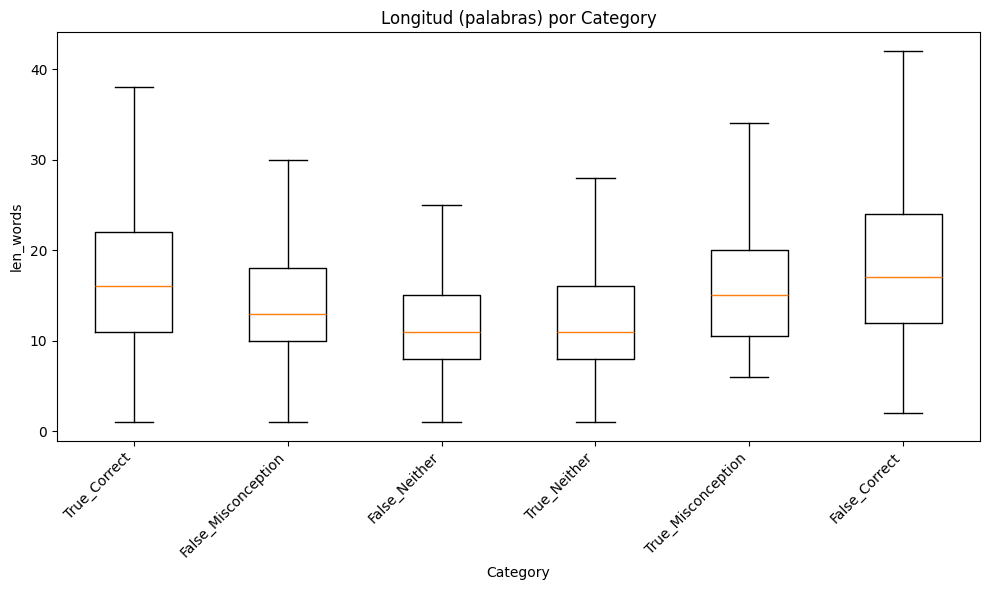

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\box_len_words_by_Category.png


In [11]:
if "len_words" in train.columns and "Category" in train.columns:
    order = train["Category"].value_counts().index.tolist()
    data = [train.loc[train["Category"]==cat, "len_words"].dropna().values for cat in order]
    plt.figure(figsize=(10,6))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.title("Longitud (palabras) por Category")
    plt.xlabel("Category")
    plt.ylabel("len_words")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    fig_path = OUT_DIR / "box_len_words_by_Category.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Boxplots (len\_words por Category)

* **Orden de medianas (aprox.)**: `False_Correct` ≳ `True_Correct` ≳ `True_Misconception` > `False_Misconception` ≳ `True_Neither` ≈ `False_Neither`.
* **Lectura**: las explicaciones **correctas** (y las “correctas con malentendido”) tienden a ser **más largas**; las **Neither** y varios **errores** son más **breves**.
* **Varianza**: `True_Correct` y `False_Correct` muestran colas más largas (outliers de respuestas muy detalladas).

---

## Dispersión: len_words vs num_digits por Category (Top 4 categorías)


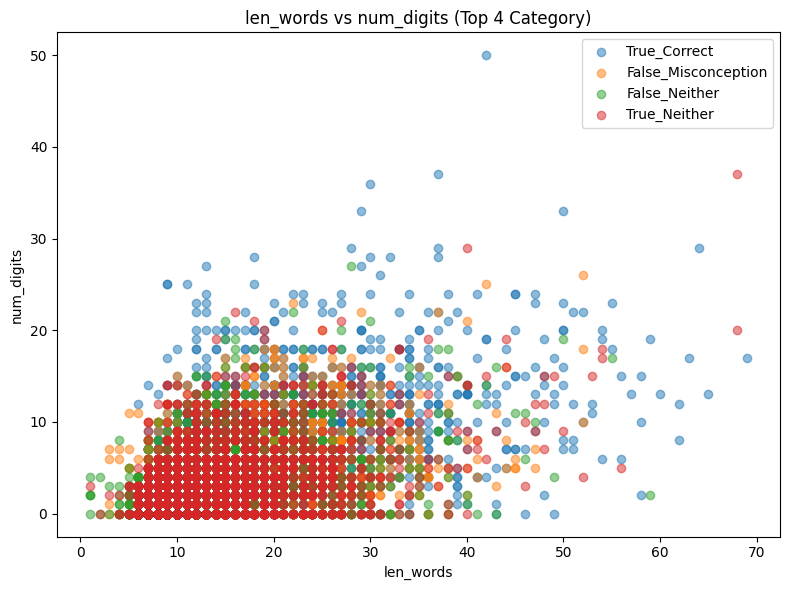

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\scatter_len_words_vs_num_digits_top4cat.png


In [12]:
if {"len_words","num_digits","Category"}.issubset(train.columns):
    top_cats = train["Category"].value_counts().head(4).index.tolist()
    plt.figure(figsize=(8,6))
    for cat in top_cats:
        dfc = train.loc[train["Category"]==cat, ["len_words","num_digits"]].dropna().sample(
            min(3000, len(train.loc[train["Category"]==cat])), random_state=42
        )
        plt.scatter(dfc["len_words"], dfc["num_digits"], alpha=0.5, label=str(cat))
    plt.title("len_words vs num_digits (Top 4 Category)")
    plt.xlabel("len_words")
    plt.ylabel("num_digits")
    plt.legend()
    plt.tight_layout()
    fig_path = OUT_DIR / "scatter_len_words_vs_num_digits_top4cat.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Dispersión (len\_words vs num\_digits, Top-4 Category)

* **Nube solapada**: gran superposición entre clases; se ve ligera **correlación positiva** (a más palabras, suelen aparecer más dígitos).
* **True\_Correct** ocupa el rango **más amplio** (llega a valores altos en ambas dimensiones).
* **Clusters**: muchas muestras en zona **corta y con pocos dígitos** (p.ej., 5–20 palabras y 0–8 dígitos).

---

## Heatmap: Category x Misconception (conteos) — primeras 20 Misconception


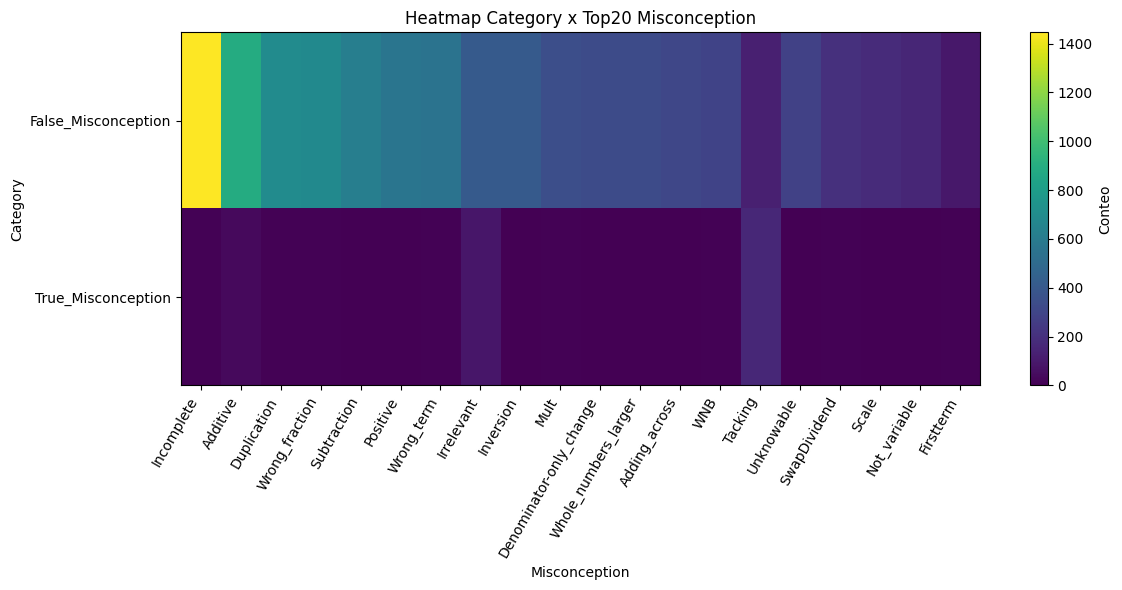

Figura guardada en: C:\Users\n8nug\Documents\Uni\2doSemestre2025\DS\DS-Proyecto02\eda_outputs\heatmap_cat_mis_top20.png


In [13]:
if "Category" in train.columns and "Misconception" in train.columns:
    ct = pd.crosstab(train["Category"], train["Misconception"])
    # Reducimos columnas a las top 20 por suma total
    top_m = ct.sum(axis=0).sort_values(ascending=False).head(20).index
    ct_top = ct[top_m]

    plt.figure(figsize=(12,6))
    plt.imshow(ct_top.values, aspect="auto")
    plt.colorbar(label="Conteo")
    plt.title("Heatmap Category x Top20 Misconception")
    plt.xlabel("Misconception")
    plt.ylabel("Category")
    plt.xticks(ticks=range(len(top_m)), labels=top_m, rotation=60, ha="right")
    plt.yticks(ticks=range(len(ct_top.index)), labels=ct_top.index)
    plt.tight_layout()
    fig_path = OUT_DIR / "heatmap_cat_mis_top20.png"
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print("Figura guardada en:", fig_path.resolve())

#### Heatmap (Category × Top-20 Misconception)

* **False\_Misconception** concentra la mayor parte de etiquetas y domina en `Incomplete`, `Additive`, `Duplication`, `Wrong_fraction`, `Subtraction`, etc.
* **True\_Misconception** queda **focalizado** en pocas etiquetas (destaca **Tacking** y **Irrelevant**).

---

# Conclusiones (hallazgos e implicaciones)

**Hallazgos clave del EDA**

* **Explicaciones cortas y sesgadas a la derecha**: mediana ≈ **13 palabras** (p75 ≈ 19; p95 ≈ 31). La mayoría son breves; hay pocos outliers muy largos.
* **Uso moderado de dígitos y escasos operadores**: mediana **4 dígitos**; la mayoría de casos no contiene operadores, con una cola de pocos ejemplos muy “numéricos”.
* **Desbalance fuerte en `Category`**: predominan `True_Correct` (\~40%) y `False_Misconception` (\~26%); `True_Misconception` (\~1.1%) y `False_Correct` (\~0.6%) son raras.
* **`Misconception` estructuralmente NA** (\~75%): coherente con que solo aplica cuando hay “Misconception”. Tras unificar etiquetas (p. ej., `Wrong_fraction`), el **Top-5** (`Incomplete`, `Additive`, `Duplication`, `Wrong_fraction`, `Subtraction`) concentra gran parte de los casos etiquetados; existe **cola larga**.
* **Patrones por cruce**:

  * `False_Misconception` se asocia a errores “operativos/clásicos” (incompleta, aditiva, duplicación, fracciones, resta).
  * `True_Misconception` concentra etiquetas como **Tacking** e **Irrelevant** (explicaciones correctas pero con razonamiento defectuoso).
* **Heterogeneidad por `QuestionId`**: algunos ítems concentran tipos de error específicos; riesgo de sobreajuste si no se valida por grupos.

**Implicaciones para las siguientes etapas**

1. **Validación y métricas**

   * Usar **GroupKFold por `QuestionId`** para medir generalización.
   * En Tarea 2 y 3 reportar **macro-F1** y **balanced accuracy**; analizar matrices de confusión por clase.
2. **Diseño del pipeline**

   * Enfoque **jerárquico**:

     * T1: Correct/Incorrect (binaria).
     * T2: Correct / Misconception / Neither.
     * T3: etiqueta específica **solo** si T2 = Misconception (evita entrenar T3 con `NA`).
3. **Manejo de desbalance**

   * **Class weights** o **focal loss**; considerar **oversampling** prudente en clases raras (p. ej., `True_Misconception`).
   * Calibración de probabilidades y **tuning de umbrales** (especialmente para el Top-5 de T3).
4. **Features y preprocesamiento**

   * Mantener limpieza “no destructiva” y **canonicalización** de etiquetas.
   * Añadir rasgos: `len_words`, `num_digits`, `num_mathops`, **ratio dígitos/palabras**, bins de dígitos, detectores de **fracciones/decimales** y comparadores.
   * Dado el texto corto, probar **n-gramas de carácter** (baseline fuerte) y un **Transformer base** con `max_length` moderado (\~128).
5. **Riesgos y controles**

   * Posible **ruido de anotación** (revisar consistencia `Category`↔`Misconception`).
   * Evitar “accuracy ilusoria” por clases mayoritarias; priorizar recall mínimo en minoritarias.

El dataset presenta respuestas cortas, fuerte desbalance y patrones de error diferenciados por categoría y pregunta. Un **pipeline jerárquico**, validado por **QuestionId**, con **ponderación de clases**, **features orientadas a contenido matemático** y **calibración** debería mejorar la detección de malentendidos y la clasificación fina de `Misconception`.
